Задание: обучить на MNIST (датасет рукописных цифр) полносвязную нейронную сеть, а также сверточную (две разных нейросети). Для этого разрешается пользоваться библиотеками tensorflow/keras/pytorch и numpy. Необходимо также использовать валидационную выборку для отслеживания эффективности работы обеих сеток и вывести графики, отображающие динамику обучения архитектур (на каждом графике кривые обучающей и валидационной выборок).

# Imports

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout
from keras.optimizers import Adam ,RMSprop
from keras import  backend as K
from keras.utils import to_categorical, plot_model
from keras.datasets import mnist

import tensorflow as tf

print(tf.__version__)

2.11.0


# Dataset

In [ ]:
# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

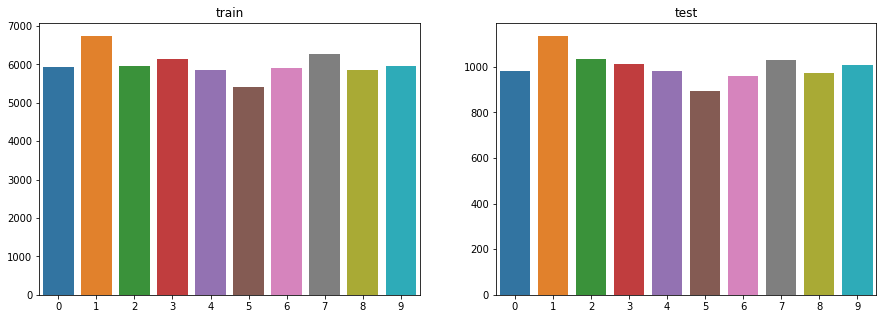

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

unique, counts = np.unique(y_train, return_counts=True)
sns.barplot(x=unique, y=counts, ax=ax[0])
ax[0].title.set_text('train')

unique, counts = np.unique(y_test, return_counts=True)
sns.barplot(x=unique, y=counts, ax=ax[1])
ax[1].title.set_text('test')

In [ ]:
np.isnan(x_train).any()

False

In [ ]:
np.isnan(x_test).any()

False

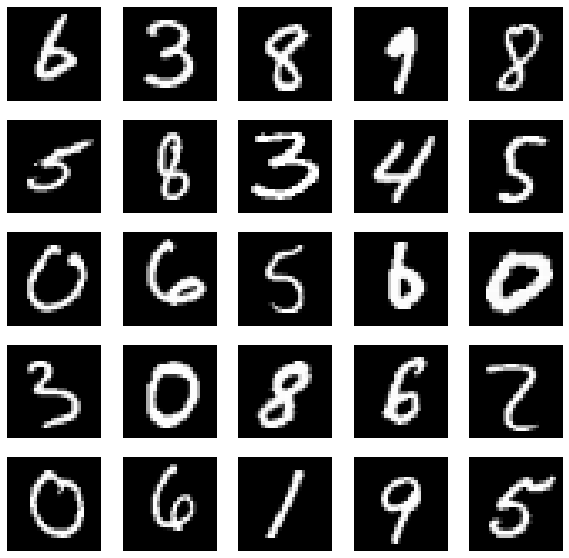

In [ ]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

# plot the 25 mnist digits
plt.figure(figsize=(10,10))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig("mnist-samples.png")
plt.close('all')


In [ ]:
# compute the number of labels
num_labels = len(np.unique(y_train))

In [ ]:
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
x_train=x_train / 255.0
x_test=x_test/255.0

# Fully Connected Network

### Prepare dataset for fully connected network

In [ ]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
input_size = image_size * image_size
input_size

784

In [ ]:
# resize and normalize
x_train_mlp = np.reshape(x_train, [-1, input_size])
x_test_mlp = np.reshape(x_test, [-1, input_size])

### Model

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.995:
      print("\nReached 99.5% accuracy so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45

In [ ]:
# model is a 3-layer MLP with ReLU and dropout after each layer
model_mlp = Sequential()
model_mlp.add(Dense(hidden_units, input_dim=input_size))
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(dropout))
model_mlp.add(Dense(hidden_units))
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(dropout))
model_mlp.add(Dense(num_labels))
model_mlp.add(Activation('softmax'))

In [ ]:
model_mlp.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_31 (Dense)            (None, 256)               200960    
                                                                 
 activation_18 (Activation)  (None, 256)               0         
                                                                 
 dropout_18 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 activation_19 (Activation)  (None, 256)               0         
                                                                 
 dropout_19 (Dropout)        (None, 256)               0         
                                                                 
 dense_33 (Dense)            (None, 10)              

In [ ]:
model_mlp.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history_mlp = model_mlp.fit(x_train_mlp, y_train, epochs=25, batch_size=batch_size, validation_split=0.1, callbacks=[callbacks])

Epoch 1/25
844/844 [==============================] - 6s 8ms/step - loss: 0.0442 - accuracy: 0.9866 - val_loss: 0.0396 - val_accuracy: 0.9868
Epoch 2/25
844/844 [==============================] - 8s 9ms/step - loss: 0.0384 - accuracy: 0.9882 - val_loss: 0.0445 - val_accuracy: 0.9878
Epoch 3/25
844/844 [==============================] - 6s 8ms/step - loss: 0.0447 - accuracy: 0.9863 - val_loss: 0.0406 - val_accuracy: 0.9898
Epoch 4/25
844/844 [==============================] - 8s 9ms/step - loss: 0.0419 - accuracy: 0.9868 - val_loss: 0.0434 - val_accuracy: 0.9910
Epoch 5/25
844/844 [==============================] - 6s 7ms/step - loss: 0.0434 - accuracy: 0.9869 - val_loss: 0.0455 - val_accuracy: 0.9882
Epoch 6/25
844/844 [==============================] - 7s 9ms/step - loss: 0.0402 - accuracy: 0.9876 - val_loss: 0.0416 - val_accuracy: 0.9900
Epoch 7/25
844/844 [==============================] - 7s 8ms/step - loss: 0.0396 - accuracy: 0.9878 - val_loss: 0.0489 - val_accuracy: 0.9887
Epoch 

### Evaluation

In [ ]:
loss_mlp, acc_mlp = model_mlp.evaluate(x_test_mlp, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc_mlp))

157/157 [==============================] - 1s 5ms/step - loss: 0.0733 - accuracy: 0.9847

Test accuracy: 98.5%


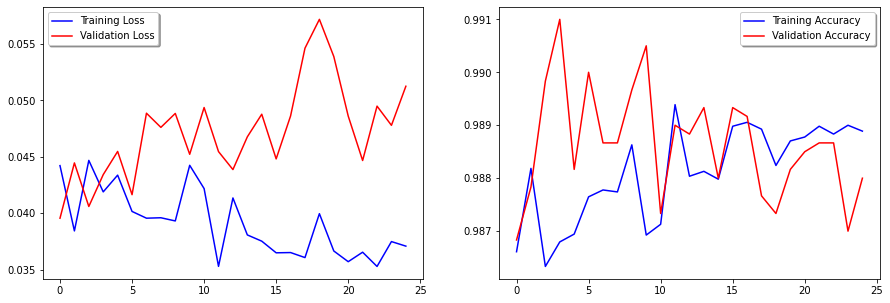

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_mlp.history['loss'], color='b', label="Training Loss")
ax[0].plot(history_mlp.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_mlp.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history_mlp.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Predict the values from the testing dataset
Y_pred = model_mlp.predict(x_test_mlp)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

313/313 [==============================] - 1s 2ms/step


<Axes: >

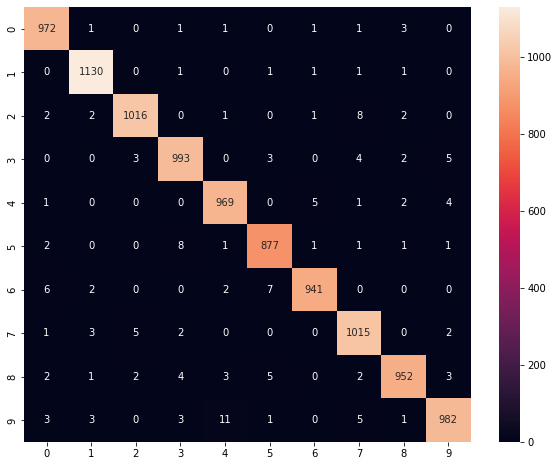

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

# Convolutional Network

### Prepare dataset for CNN

In [ ]:
input_shape = (28, 28, 1)

x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

### Model

In [ ]:
batch_size = 64
num_classes = 10
epochs = 5

In [ ]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model_cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model_cnn.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_26 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_19 (Conv2D)          (None, 14, 14, 64)        36928     
                                                     

In [ ]:
history_cnn = model_cnn.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5
844/844 [==============================] - 447s 528ms/step - loss: 0.2419 - accuracy: 0.9256 - val_loss: 0.0464 - val_accuracy: 0.9863
Epoch 2/5
844/844 [==============================] - 424s 503ms/step - loss: 0.0810 - accuracy: 0.9759 - val_loss: 0.0316 - val_accuracy: 0.9918
Epoch 3/5
844/844 [==============================] - 433s 512ms/step - loss: 0.0616 - accuracy: 0.9816 - val_loss: 0.0286 - val_accuracy: 0.9917
Epoch 4/5
844/844 [==============================] - 423s 502ms/step - loss: 0.0505 - accuracy: 0.9851 - val_loss: 0.0304 - val_accuracy: 0.9923
Epoch 5/5
844/844 [==============================] - 421s 499ms/step - loss: 0.0439 - accuracy: 0.9876 - val_loss: 0.0302 - val_accuracy: 0.9915


### Evaluation

In [ ]:
loss_cnn, acc_cnn = model_cnn.evaluate(x_test_cnn, y_test)
print("\nTest accuracy: %.1f%%" % (100.0 * acc_cnn))

313/313 [==============================] - 23s 74ms/step - loss: 0.0235 - accuracy: 0.9923

Test accuracy: 99.2%


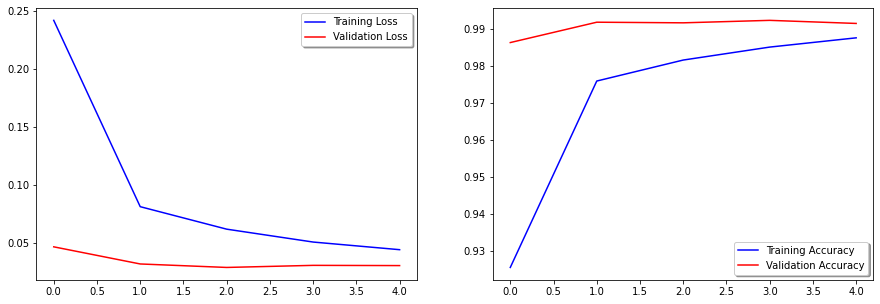

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_cnn.history['loss'], color='b', label="Training Loss")
ax[0].plot(history_cnn.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history_cnn.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history_cnn.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
# Predict the values from the testing dataset
Y_pred = model_cnn.predict(x_test_cnn)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert testing observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1)
# compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(Y_true, Y_pred_classes)

313/313 [==============================] - 18s 59ms/step


<Axes: >

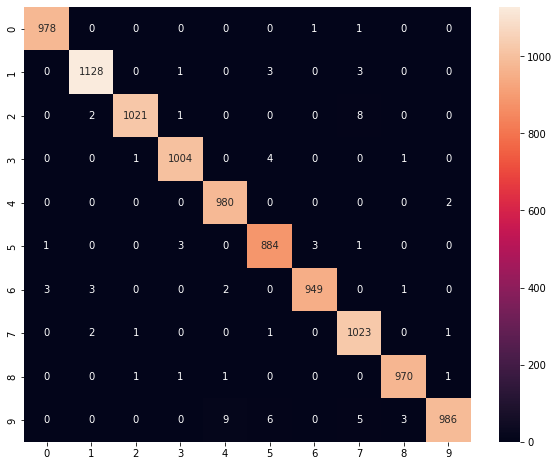

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='g')

# Results

Были обучены 2 нейросети: полносвязная и сверточная на датасете MNIST. Сверточная нейросеть показала себя немного лучше (99.2% против 98.5% accuracy). Были построены графики ошибок и корреляционные матрицы.